# Lab 2 Transfer Learning Model

Ziyuan Tang

In [70]:
from PIL import Image
from tensorflow.keras.datasets import cifar10
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import glob,os


## 1. Confusion Matrix Plot Function

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## 2. Define Models

### 2.1 Import Old Model

In [3]:
import keras
model=keras.models.load_model('model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

### 2.1 Build New Model

Transfer weight of 1-7 layers to new model with unfreezed weight and freezed weight

In [17]:
## build all 14 tf models
layer_index=[19,14,12,8,6,2,0]
layer_func = [Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
             BatchNormalization(),Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),MaxPool2D((2, 2)),Dropout(0.2),Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),BatchNormalization(),
             MaxPool2D((2, 2)),Dropout(0.3),Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),MaxPool2D((2, 2)),Dropout(0.4),Flatten(),Dense(128, activation='relu', kernel_initializer='he_uniform'),
             BatchNormalization(),Dropout(0.5),Dense(11, activation='softmax')]

model_tf_unfreezed =[]
model_tf_freezed = []

for i in layer_index:

    model_new = keras.Model(inputs=model.input, outputs=model.layers[i].output)
    model_new_unfreezed = keras.Sequential()
    model_new_unfreezed.add(model_new)
        

        
    model_new_freezed = keras.Sequential()
    model_new_freezed.add(model_new)
        
    model_tf_unfreezed.append(model_new_unfreezed)
    model_tf_freezed.append(model_new_freezed)

In [28]:
for i in range(len(model_tf_freezed)):
     model_tf_freezed[i].layers[0].trainable=False

Layer: 0, Trainable: False
Layer: 1, Trainable: True
Layer: 2, Trainable: True
Layer: 3, Trainable: True
Layer: 4, Trainable: True
Layer: 5, Trainable: True
Layer: 6, Trainable: True
Layer: 7, Trainable: True
Layer: 8, Trainable: True


## 3. Load and Preprocessing Data

In [9]:
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

instances = []
images_path='converted-agumented'
# Load in the images
for filepath in os.listdir(images_path):  
    image=( Image.open(images_path+"/"+filepath))
    data=np.asarray(image)
    if data.shape!=(32,32,3): 
        print(filepath)
        continue
    instances.append(data)

bobcats=np.stack(instances, axis=0)
print(bobcats.shape)
bobcat_group=np.arange(len(instances)).reshape(len(instances),1); 
bobcat_group.fill(10)

x_train=np.concatenate((x_train,bobcats[:5000,:,:,:]),axis=0)
x_test=np.concatenate((x_test,bobcats[5000:,:,:,:]),axis=0)
y_train=np.concatenate((y_train,bobcat_group[:5000]),axis=0)
y_test=np.concatenate((y_test,bobcat_group[5000:]),axis=0)

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))


a= to_categorical(y_train)

print('Shape of y_train after to_categorical is {}'.format(a.shape))
# Normalizing
x_train=x_train/255
x_test=x_test/255

#One hot encoding
y_train_cat=to_categorical(y_train,11)
y_test_cat=to_categorical(y_test,11)

print(y_train_cat.shape)
print(y_test_cat.shape)

(6000, 32, 32, 3)
Shape of x_train is (55000, 32, 32, 3)
Shape of x_test is (11000, 32, 32, 3)
Shape of y_train is (55000, 1)
Shape of y_test is (11000, 1)
Shape of y_train after to_categorical is (55000, 11)
(55000, 11)
(11000, 11)


## 4. Train Models

In [29]:
## Freezed
history_freezed =[]
opt = SGD(learning_rate=0.001, momentum=0.9)
for i in model_tf_freezed:
    i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
    history=i.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat))
    history_freezed.append(history)
    
with open("history_fz.txt","w") as hist_fz:
    hist_fz.write(str(history_freezed))
        

# save model
for i in range(len(model_tf_freezed)):
    model_tf_freezed[i].save('freezed_'+str(i)+'.h5')

Epoch 1/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3382 - accuracy: 0.8793 - val_loss: 0.5526 - val_accuracy: 0.8241
Epoch 2/50
1719/1719 [==============================] - 27s 15ms/step - loss: 0.3342 - accuracy: 0.8804 - val_loss: 0.5572 - val_accuracy: 0.8211
Epoch 3/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3339 - accuracy: 0.8812 - val_loss: 0.5602 - val_accuracy: 0.8225
Epoch 4/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3345 - accuracy: 0.8792 - val_loss: 0.5577 - val_accuracy: 0.8237
Epoch 5/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3365 - accuracy: 0.8799 - val_loss: 0.5617 - val_accuracy: 0.8205
Epoch 6/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3296 - accuracy: 0.8817 - val_loss: 0.5548 - val_accuracy: 0.8234
Epoch 7/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3340 - accuracy: 0.8798 - val_loss: 0.5498 -

Epoch 7/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2982 - accuracy: 0.8978 - val_loss: 0.4952 - val_accuracy: 0.8435
Epoch 8/50
1719/1719 [==============================] - 45s 26ms/step - loss: 0.2919 - accuracy: 0.8981 - val_loss: 0.4911 - val_accuracy: 0.8445
Epoch 9/50
1719/1719 [==============================] - 41s 24ms/step - loss: 0.2875 - accuracy: 0.8991 - val_loss: 0.4862 - val_accuracy: 0.8483
Epoch 10/50
1719/1719 [==============================] - 44s 26ms/step - loss: 0.2840 - accuracy: 0.9006 - val_loss: 0.4932 - val_accuracy: 0.8464
Epoch 11/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2814 - accuracy: 0.9027 - val_loss: 0.4922 - val_accuracy: 0.8464
Epoch 12/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2755 - accuracy: 0.9053 - val_loss: 0.4893 - val_accuracy: 0.8473
Epoch 13/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2775 - accuracy: 0.9056 - val_loss: 0.49

Epoch 13/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.2633 - accuracy: 0.9099 - val_loss: 0.4481 - val_accuracy: 0.8597
Epoch 14/50
1719/1719 [==============================] - 47s 28ms/step - loss: 0.2563 - accuracy: 0.9123 - val_loss: 0.4605 - val_accuracy: 0.8591
Epoch 15/50
1719/1719 [==============================] - 59s 34ms/step - loss: 0.2507 - accuracy: 0.9131 - val_loss: 0.4646 - val_accuracy: 0.8596
Epoch 16/50
1719/1719 [==============================] - 66s 38ms/step - loss: 0.2480 - accuracy: 0.9145 - val_loss: 0.4548 - val_accuracy: 0.8593
Epoch 17/50
1719/1719 [==============================] - 68s 39ms/step - loss: 0.2420 - accuracy: 0.9154 - val_loss: 0.4733 - val_accuracy: 0.8575
Epoch 18/50
1719/1719 [==============================] - 65s 38ms/step - loss: 0.2399 - accuracy: 0.9168 - val_loss: 0.4574 - val_accuracy: 0.8626
Epoch 19/50
1719/1719 [==============================] - 86s 50ms/step - loss: 0.2343 - accuracy: 0.9185 - val_loss: 0

Epoch 19/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.1954 - accuracy: 0.9333 - val_loss: 0.4338 - val_accuracy: 0.8737
Epoch 20/50
1719/1719 [==============================] - 46s 27ms/step - loss: 0.1958 - accuracy: 0.9330 - val_loss: 0.4222 - val_accuracy: 0.8784
Epoch 21/50
1719/1719 [==============================] - 45s 26ms/step - loss: 0.1968 - accuracy: 0.9319 - val_loss: 0.4314 - val_accuracy: 0.8747
Epoch 22/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.1961 - accuracy: 0.9316 - val_loss: 0.4400 - val_accuracy: 0.8715
Epoch 23/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.1895 - accuracy: 0.9326 - val_loss: 0.4368 - val_accuracy: 0.8703
Epoch 24/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.1900 - accuracy: 0.9337 - val_loss: 0.4448 - val_accuracy: 0.8740
Epoch 25/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.1838 - accuracy: 0.9369 - val_loss: 0

Epoch 25/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1532 - accuracy: 0.9473 - val_loss: 0.4413 - val_accuracy: 0.8780
Epoch 26/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1488 - accuracy: 0.9495 - val_loss: 0.4508 - val_accuracy: 0.8788
Epoch 27/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1454 - accuracy: 0.9492 - val_loss: 0.4396 - val_accuracy: 0.8807
Epoch 28/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1496 - accuracy: 0.9483 - val_loss: 0.4401 - val_accuracy: 0.8767
Epoch 29/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1472 - accuracy: 0.9480 - val_loss: 0.4318 - val_accuracy: 0.8810
Epoch 30/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1468 - accuracy: 0.9510 - val_loss: 0.4347 - val_accuracy: 0.8833
Epoch 31/50
1719/1719 [==============================] - 63s 37ms/step - loss: 0.1461 - accuracy: 0.9500 - val_loss: 0

Epoch 31/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1278 - accuracy: 0.9564 - val_loss: 0.4381 - val_accuracy: 0.8823
Epoch 32/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1256 - accuracy: 0.9572 - val_loss: 0.4329 - val_accuracy: 0.8841
Epoch 33/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1271 - accuracy: 0.9563 - val_loss: 0.4385 - val_accuracy: 0.8848
Epoch 34/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1261 - accuracy: 0.9567 - val_loss: 0.4302 - val_accuracy: 0.8855
Epoch 35/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1287 - accuracy: 0.9564 - val_loss: 0.4339 - val_accuracy: 0.8858
Epoch 36/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1239 - accuracy: 0.9577 - val_loss: 0.4349 - val_accuracy: 0.8842
Epoch 37/50
1719/1719 [==============================] - 79s 46ms/step - loss: 0.1260 - accuracy: 0.9563 - val_loss: 0

In [7]:

## Unfreezed
history_unfreezed =[]
opt = SGD(lr=0.001, momentum=0.9)
for i in model_tf_unfreezed:
    i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
    history=i.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat))
    history_unfreezed.append(history)

with open("history_unfz.txt","w") as hist_unfz:
    hist_unfz.write(str(history_unfreezed))

for i in range(len(model_tf_unfreezed)):
    model_tf_unfreezed[i].save('unfreezed_'+str(i)+'.h5')

Epoch 1/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.5411 - accuracy: 0.8154 - val_loss: 0.5561 - val_accuracy: 0.8203
Epoch 2/50
1719/1719 [==============================] - 25s 14ms/step - loss: 0.3485 - accuracy: 0.8757 - val_loss: 0.5535 - val_accuracy: 0.8222
Epoch 3/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3450 - accuracy: 0.8775 - val_loss: 0.5511 - val_accuracy: 0.8207
Epoch 4/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3395 - accuracy: 0.8788 - val_loss: 0.5511 - val_accuracy: 0.8215
Epoch 5/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3380 - accuracy: 0.8790 - val_loss: 0.5498 - val_accuracy: 0.8225
Epoch 6/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3348 - accuracy: 0.8808 - val_loss: 0.5652 - val_accuracy: 0.8196
Epoch 7/50
1719/1719 [==============================] - 27s 15ms/step - loss: 0.3364 - accuracy: 0.8807 - val_loss: 0.5492 -

Epoch 7/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2966 - accuracy: 0.8978 - val_loss: 0.4874 - val_accuracy: 0.8456
Epoch 8/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2936 - accuracy: 0.8985 - val_loss: 0.4970 - val_accuracy: 0.8446
Epoch 9/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2832 - accuracy: 0.9015 - val_loss: 0.4889 - val_accuracy: 0.8491
Epoch 10/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2812 - accuracy: 0.9010 - val_loss: 0.4931 - val_accuracy: 0.8480
Epoch 11/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2777 - accuracy: 0.9033 - val_loss: 0.4842 - val_accuracy: 0.8495
Epoch 12/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2769 - accuracy: 0.9044 - val_loss: 0.4880 - val_accuracy: 0.8532
Epoch 13/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2786 - accuracy: 0.9044 - val_loss: 0.49

Epoch 13/50
1719/1719 [==============================] - 42s 24ms/step - loss: 0.2603 - accuracy: 0.9095 - val_loss: 0.4677 - val_accuracy: 0.8562
Epoch 14/50
1719/1719 [==============================] - 42s 25ms/step - loss: 0.2554 - accuracy: 0.9125 - val_loss: 0.4463 - val_accuracy: 0.8620
Epoch 15/50
1719/1719 [==============================] - 42s 25ms/step - loss: 0.2481 - accuracy: 0.9132 - val_loss: 0.4482 - val_accuracy: 0.8638
Epoch 16/50
1719/1719 [==============================] - 42s 24ms/step - loss: 0.2458 - accuracy: 0.9152 - val_loss: 0.4559 - val_accuracy: 0.8606
Epoch 17/50
1719/1719 [==============================] - 42s 24ms/step - loss: 0.2386 - accuracy: 0.9164 - val_loss: 0.4624 - val_accuracy: 0.8609
Epoch 18/50
1719/1719 [==============================] - 42s 24ms/step - loss: 0.2370 - accuracy: 0.9174 - val_loss: 0.4494 - val_accuracy: 0.8618
Epoch 19/50
1719/1719 [==============================] - 42s 24ms/step - loss: 0.2320 - accuracy: 0.9189 - val_loss: 0

Epoch 19/50
1719/1719 [==============================] - 46s 27ms/step - loss: 0.1988 - accuracy: 0.9311 - val_loss: 0.4514 - val_accuracy: 0.8687
Epoch 20/50
1719/1719 [==============================] - 46s 27ms/step - loss: 0.1952 - accuracy: 0.9323 - val_loss: 0.4371 - val_accuracy: 0.8700
Epoch 21/50
1719/1719 [==============================] - 46s 27ms/step - loss: 0.1955 - accuracy: 0.9319 - val_loss: 0.4286 - val_accuracy: 0.8696
Epoch 22/50
1719/1719 [==============================] - 46s 27ms/step - loss: 0.1920 - accuracy: 0.9336 - val_loss: 0.4468 - val_accuracy: 0.8720
Epoch 23/50
1719/1719 [==============================] - 46s 27ms/step - loss: 0.1900 - accuracy: 0.9343 - val_loss: 0.4273 - val_accuracy: 0.8754
Epoch 24/50
1719/1719 [==============================] - 47s 27ms/step - loss: 0.1858 - accuracy: 0.9348 - val_loss: 0.4397 - val_accuracy: 0.8745
Epoch 25/50
1719/1719 [==============================] - 48s 28ms/step - loss: 0.1866 - accuracy: 0.9350 - val_loss: 0

Epoch 25/50
1719/1719 [==============================] - 68s 39ms/step - loss: 0.1519 - accuracy: 0.9481 - val_loss: 0.4417 - val_accuracy: 0.8770
Epoch 26/50
1719/1719 [==============================] - 68s 39ms/step - loss: 0.1513 - accuracy: 0.9474 - val_loss: 0.4256 - val_accuracy: 0.8804
Epoch 27/50
1719/1719 [==============================] - 68s 40ms/step - loss: 0.1496 - accuracy: 0.9484 - val_loss: 0.4368 - val_accuracy: 0.8812
Epoch 28/50
1719/1719 [==============================] - 68s 40ms/step - loss: 0.1502 - accuracy: 0.9488 - val_loss: 0.4314 - val_accuracy: 0.8782
Epoch 29/50
1719/1719 [==============================] - 68s 40ms/step - loss: 0.1428 - accuracy: 0.9508 - val_loss: 0.4493 - val_accuracy: 0.8770
Epoch 30/50
1719/1719 [==============================] - 68s 40ms/step - loss: 0.1461 - accuracy: 0.9488 - val_loss: 0.4436 - val_accuracy: 0.8752
Epoch 31/50
1719/1719 [==============================] - 68s 40ms/step - loss: 0.1436 - accuracy: 0.9511 - val_loss: 0

Epoch 31/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1271 - accuracy: 0.9562 - val_loss: 0.4332 - val_accuracy: 0.8840
Epoch 32/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1267 - accuracy: 0.9564 - val_loss: 0.4487 - val_accuracy: 0.8782
Epoch 33/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1271 - accuracy: 0.9559 - val_loss: 0.4260 - val_accuracy: 0.8852
Epoch 34/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1273 - accuracy: 0.9555 - val_loss: 0.4227 - val_accuracy: 0.8828
Epoch 35/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1248 - accuracy: 0.9572 - val_loss: 0.4245 - val_accuracy: 0.8874
Epoch 36/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1257 - accuracy: 0.9564 - val_loss: 0.4183 - val_accuracy: 0.8855
Epoch 37/50
1719/1719 [==============================] - 82s 48ms/step - loss: 0.1232 - accuracy: 0.9578 - val_loss: 0

C:\Users\15047\anaconda3\envs\ensf511\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3884 - accuracy: 0.8715 - val_loss: 0.5565 - val_accuracy: 0.8213
Epoch 2/50
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3524 - accuracy: 0.8746 - val_loss: 0.5543 - val_accuracy: 0.8215
Epoch 3/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3482 - accuracy: 0.8766 - val_loss: 0.5528 - val_accuracy: 0.8217
Epoch 4/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3396 - accuracy: 0.8792 - val_loss: 0.5569 - val_accuracy: 0.8207
Epoch 5/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3431 - accuracy: 0.8779 - val_loss: 0.5570 - val_accuracy: 0.8198
Epoch 6/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3390 - accuracy: 0.8785 - val_loss: 0.5652 - val_accuracy: 0.8175
Epoch 7/50
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3384 - accuracy: 0.8797 - val_loss: 0.5584 -

Epoch 7/50
1719/1719 [==============================] - 29s 17ms/step - loss: 0.2792 - accuracy: 0.9045 - val_loss: 0.4887 - val_accuracy: 0.8473
Epoch 8/50
1719/1719 [==============================] - 30s 17ms/step - loss: 0.2780 - accuracy: 0.9037 - val_loss: 0.4954 - val_accuracy: 0.8435
Epoch 9/50
1719/1719 [==============================] - 30s 17ms/step - loss: 0.2716 - accuracy: 0.9059 - val_loss: 0.4902 - val_accuracy: 0.8475
Epoch 10/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2688 - accuracy: 0.9067 - val_loss: 0.4932 - val_accuracy: 0.8448
Epoch 11/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2636 - accuracy: 0.9096 - val_loss: 0.4992 - val_accuracy: 0.8465
Epoch 12/50
1719/1719 [==============================] - 30s 17ms/step - loss: 0.2583 - accuracy: 0.9113 - val_loss: 0.4970 - val_accuracy: 0.8469
Epoch 13/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2597 - accuracy: 0.9104 - val_loss: 0.49

Epoch 13/50
1719/1719 [==============================] - 39s 23ms/step - loss: 0.1685 - accuracy: 0.9409 - val_loss: 0.4710 - val_accuracy: 0.8709
Epoch 14/50
1719/1719 [==============================] - 40s 23ms/step - loss: 0.1701 - accuracy: 0.9412 - val_loss: 0.4656 - val_accuracy: 0.8690
Epoch 15/50
1719/1719 [==============================] - 40s 23ms/step - loss: 0.1763 - accuracy: 0.9396 - val_loss: 0.4708 - val_accuracy: 0.8663
Epoch 16/50
1719/1719 [==============================] - 40s 23ms/step - loss: 0.1670 - accuracy: 0.9419 - val_loss: 0.4597 - val_accuracy: 0.8718
Epoch 17/50
1719/1719 [==============================] - 40s 23ms/step - loss: 0.1653 - accuracy: 0.9429 - val_loss: 0.4630 - val_accuracy: 0.8695
Epoch 18/50
1719/1719 [==============================] - 40s 23ms/step - loss: 0.1617 - accuracy: 0.9444 - val_loss: 0.4696 - val_accuracy: 0.8692
Epoch 19/50
1719/1719 [==============================] - 40s 23ms/step - loss: 0.1670 - accuracy: 0.9427 - val_loss: 0

Epoch 19/50
1719/1719 [==============================] - 50s 29ms/step - loss: 0.1190 - accuracy: 0.9592 - val_loss: 0.4677 - val_accuracy: 0.8786
Epoch 20/50
1719/1719 [==============================] - 51s 29ms/step - loss: 0.1167 - accuracy: 0.9598 - val_loss: 0.4568 - val_accuracy: 0.8799
Epoch 21/50
1719/1719 [==============================] - 51s 29ms/step - loss: 0.1179 - accuracy: 0.9598 - val_loss: 0.4622 - val_accuracy: 0.8794
Epoch 22/50
1719/1719 [==============================] - 51s 29ms/step - loss: 0.1137 - accuracy: 0.9610 - val_loss: 0.4574 - val_accuracy: 0.8810
Epoch 23/50
1719/1719 [==============================] - 51s 29ms/step - loss: 0.1125 - accuracy: 0.9607 - val_loss: 0.4834 - val_accuracy: 0.8750
Epoch 24/50
1719/1719 [==============================] - 51s 29ms/step - loss: 0.1133 - accuracy: 0.9612 - val_loss: 0.4592 - val_accuracy: 0.8800
Epoch 25/50
1719/1719 [==============================] - 51s 29ms/step - loss: 0.1125 - accuracy: 0.9620 - val_loss: 0

Epoch 25/50
1719/1719 [==============================] - 69s 40ms/step - loss: 0.0968 - accuracy: 0.9666 - val_loss: 0.4631 - val_accuracy: 0.8843
Epoch 26/50
1719/1719 [==============================] - 69s 40ms/step - loss: 0.0965 - accuracy: 0.9666 - val_loss: 0.4758 - val_accuracy: 0.8815
Epoch 27/50
1719/1719 [==============================] - 69s 40ms/step - loss: 0.0948 - accuracy: 0.9689 - val_loss: 0.4671 - val_accuracy: 0.8820
Epoch 28/50
1719/1719 [==============================] - 69s 40ms/step - loss: 0.0963 - accuracy: 0.9671 - val_loss: 0.4556 - val_accuracy: 0.8870
Epoch 29/50
1719/1719 [==============================] - 69s 40ms/step - loss: 0.0950 - accuracy: 0.9675 - val_loss: 0.4687 - val_accuracy: 0.8810
Epoch 30/50
1719/1719 [==============================] - 69s 40ms/step - loss: 0.0924 - accuracy: 0.9678 - val_loss: 0.4626 - val_accuracy: 0.8855
Epoch 31/50
1719/1719 [==============================] - 70s 41ms/step - loss: 0.0908 - accuracy: 0.9690 - val_loss: 0

Epoch 31/50
1719/1719 [==============================] - 83s 48ms/step - loss: 0.0894 - accuracy: 0.9696 - val_loss: 0.4685 - val_accuracy: 0.8840
Epoch 32/50
1719/1719 [==============================] - 83s 48ms/step - loss: 0.0859 - accuracy: 0.9710 - val_loss: 0.4515 - val_accuracy: 0.8871
Epoch 33/50
1719/1719 [==============================] - 83s 48ms/step - loss: 0.0899 - accuracy: 0.9688 - val_loss: 0.4452 - val_accuracy: 0.8864
Epoch 34/50
1719/1719 [==============================] - 84s 49ms/step - loss: 0.0900 - accuracy: 0.9691 - val_loss: 0.4604 - val_accuracy: 0.8843
Epoch 35/50
1719/1719 [==============================] - 84s 49ms/step - loss: 0.0889 - accuracy: 0.9695 - val_loss: 0.4504 - val_accuracy: 0.8864
Epoch 36/50
1719/1719 [==============================] - 83s 49ms/step - loss: 0.0878 - accuracy: 0.9697 - val_loss: 0.4626 - val_accuracy: 0.8853
Epoch 37/50
1719/1719 [==============================] - 84s 49ms/step - loss: 0.0863 - accuracy: 0.9706 - val_loss: 0

TypeError: write() argument must be str, not list

## 5. Confusion Matrix

### 5.1 Freezed Layer

Normalized confusion matrix


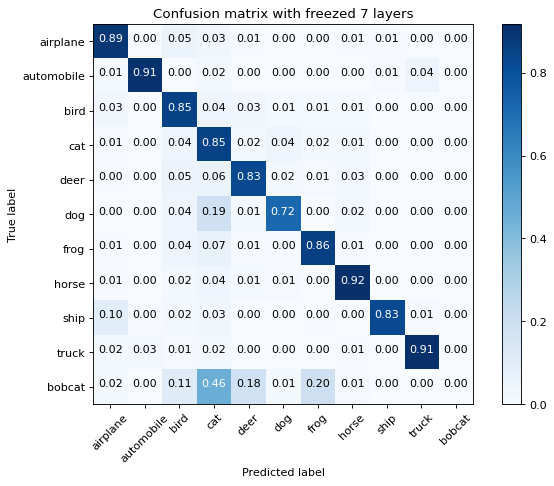

Normalized confusion matrix


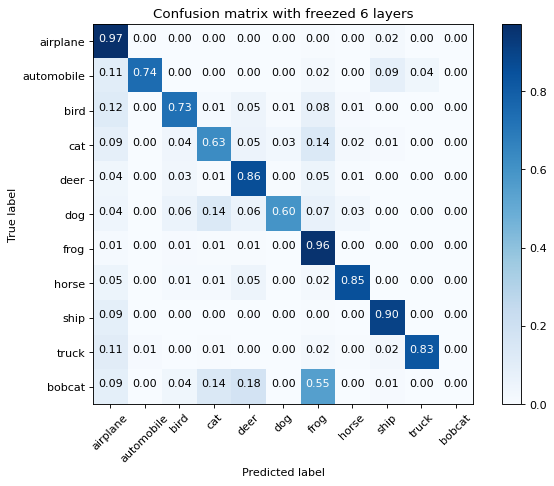

Normalized confusion matrix


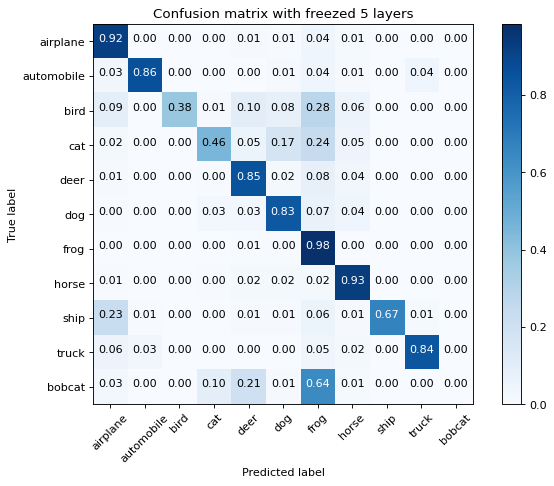

Normalized confusion matrix


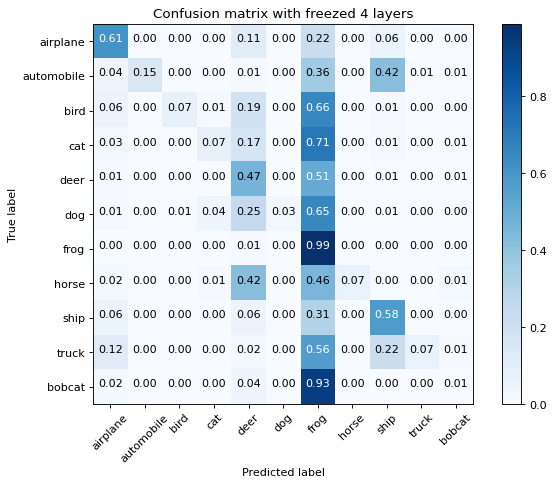

Normalized confusion matrix


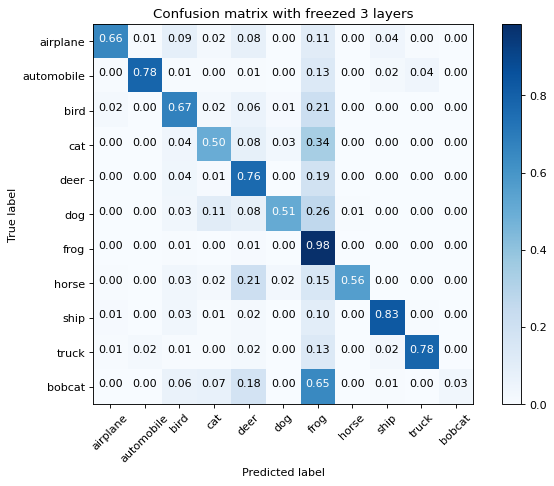

Normalized confusion matrix


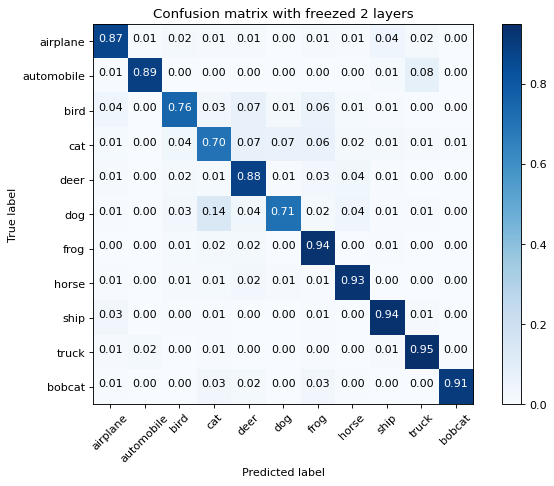

Normalized confusion matrix


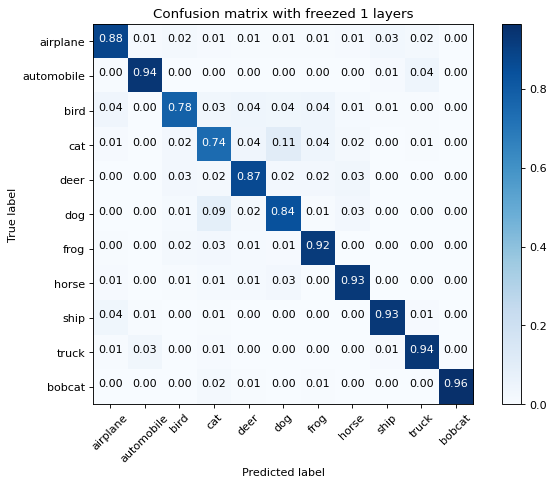

In [85]:
for i in range(7):
    file = 'freezed_'+str(i)+'.h5'
    new_model = keras.models.load_model(file)
    p_test = new_model.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(8, 6), dpi=80)
    plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title='Confusion matrix with freezed '+str(7-i)+" layers")

### Discussion

When more layers' weight are transferred, the model tend to not recognize bobcat correctly, the reason may be that the original model did not have bobcat class and the transferred model does not have enough layers to train to classify bobcat. This might also indicate that the first two layers have the most weight to predict the result.



### 5.2 Unfreezed Model

Normalized confusion matrix


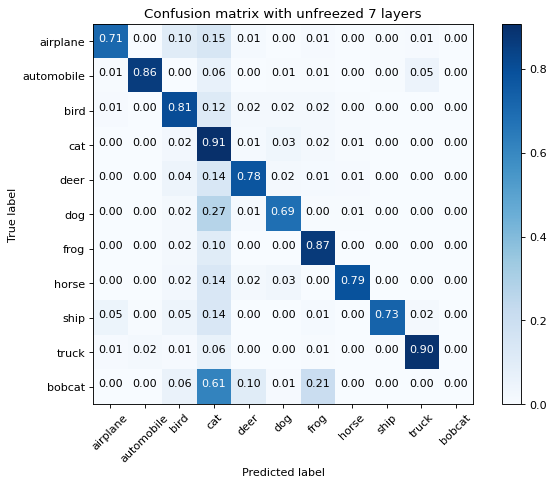

Normalized confusion matrix


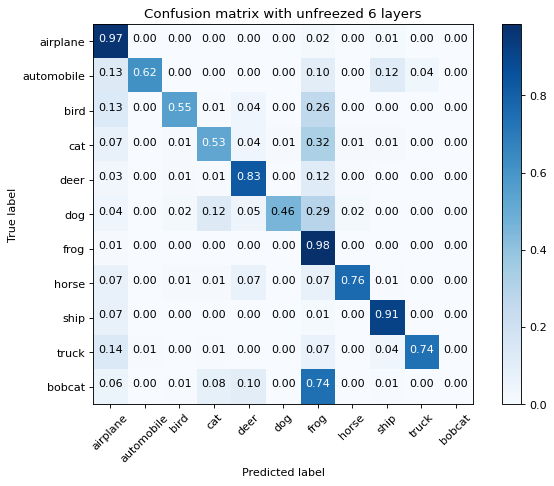

Normalized confusion matrix


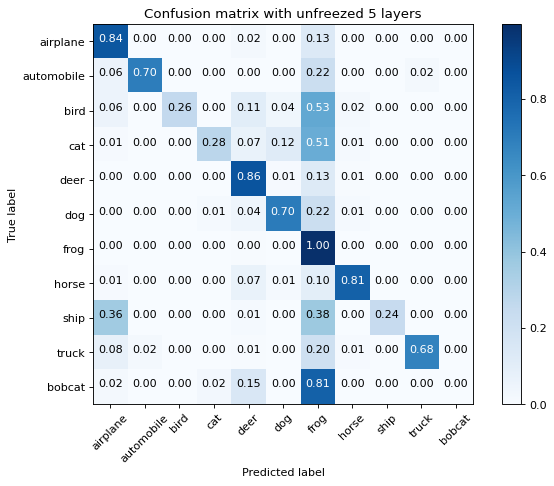

Normalized confusion matrix


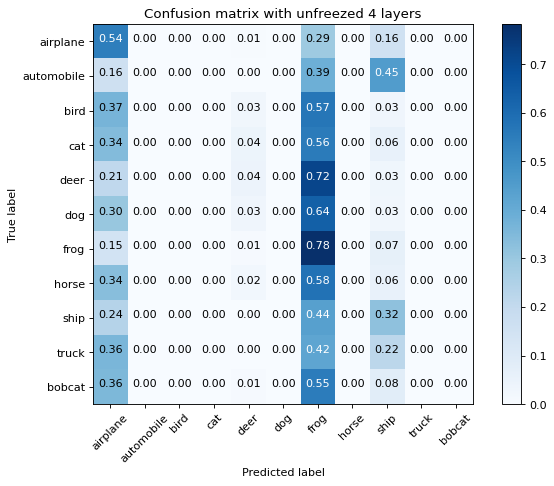

Normalized confusion matrix


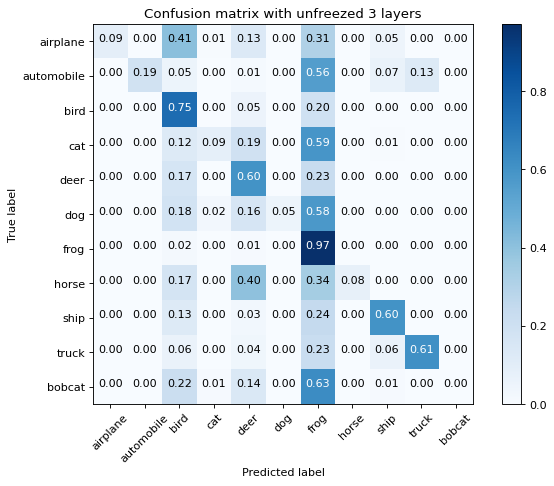

Normalized confusion matrix


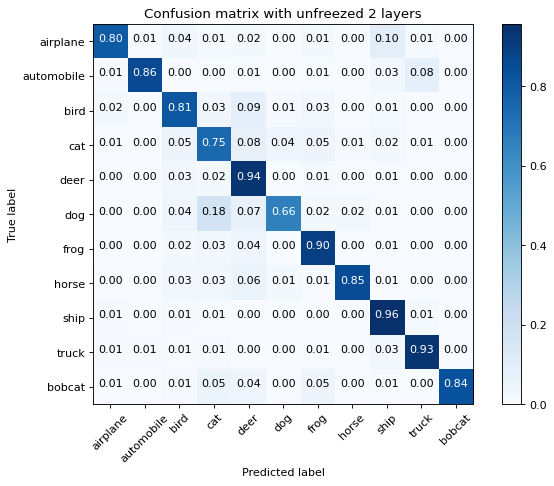

Normalized confusion matrix


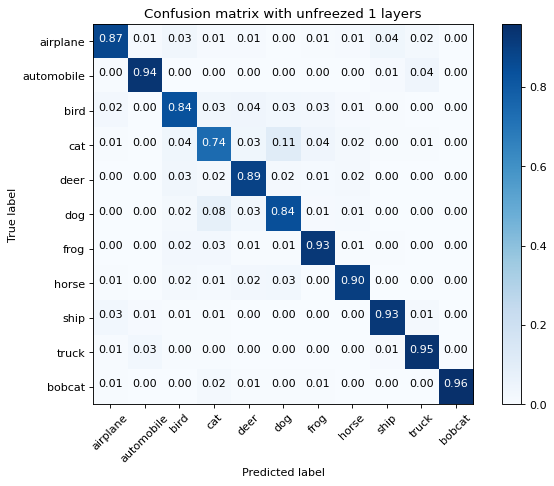

In [87]:
for i in range(7):
    file = 'unfreezed_'+str(i)+'.h5'
    new_model = keras.models.load_model(file)
    p_test = new_model.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(8, 6), dpi=80)
    plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title='Confusion matrix with unfreezed '+str(7-i)+" layers")

## 6. Plot Accuracies
### 6.1 Overall Accuracy

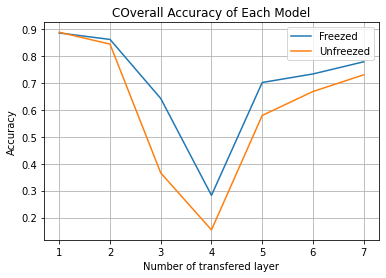

In [82]:
acc_fz =[]
acc_unfz =[]
for i in range(7):
    file = 'unfreezed_'+str(6-i)+'.h5'
    new_model = keras.models.load_model(file)
    p_test = new_model.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    true_positive = 0
    for j in range(len(cm)):
        true_positive+=cm[j][j]
    acc = true_positive/np.sum(cm)
    acc_unfz.append(acc)
    
    file = 'freezed_'+str(6-i)+'.h5'
    new_model = keras.models.load_model(file)
    p_test = new_model.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    true_positive = 0
    for j in range(len(cm)):
        true_positive+=cm[j][j]
    acc = true_positive/np.sum(cm)    
    acc_fz.append(acc)

plt.plot(x,acc_fz,x,acc_unfz)
plt.grid()
plt.title("Overall Accuracy of Each Model")
plt.xlabel("Number of transfered layer")
plt.ylabel("Accuracy")
plt.legend(["Freezed","Unfreezed"])

### 6.2 Cat Detection Accuracy

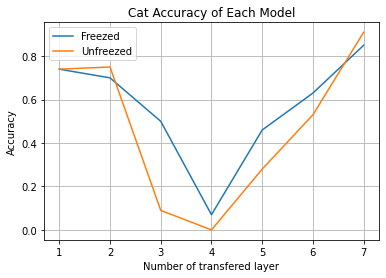

In [65]:
# from confusion matrix
x =[1,2,3,4,5,6,7]
fz_accuracy = [0.74, 0.7, 0.5, 0.07, 0.46, 0.63, 0.85]
unfz_accuracy = [0.74, 0.75, 0.09, 0, 0.28, 0.53, 0.91]

plt.plot(x,fz_accuracy,x,unfz_accuracy)
plt.grid()
plt.title("Cat Accuracy of Each Model")
plt.xlabel("Number of transfered layer")
plt.ylabel("Accuracy")
plt.legend(["Freezed","Unfreezed"])

### 6.3 Bobcat Detection Accuracy

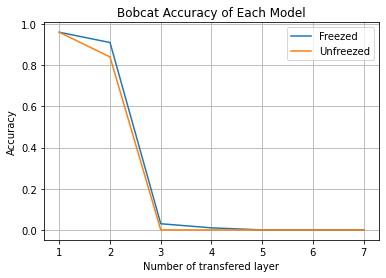

In [78]:
# from confusion matrix
x =[1,2,3,4,5,6,7]
fz_accuracy = [0.96, 0.91, 0.03, 0.01, 0, 0, 0]
unfz_accuracy = [0.96,0.84,0.0,0,0,0,0]

plt.plot(x,fz_accuracy,x,unfz_accuracy)
plt.grid()
plt.title("Bobcat Accuracy of Each Model")
plt.xlabel("Number of transfered layer")
plt.ylabel("Accuracy")
plt.legend(["Freezed","Unfreezed"])

### Discussion

The overall accuracy of freezed weight transfer learning plot follows the result indicated in the paper `NIPS-2014-how-transferable-are-features-in-deep-neural-networks-Paper` as it drops down during freezing intermediate layers; the unfreezed learning, however, does not have a simaliar accuracy over transferring different layers as indicated in the paper. This result
may be caused by unproper choices of learning rate.

Transferring layer 5-7 have a better model accuracy for both freezed and unfreezed models; however, the targeted value `Bobcat` cannot be recognized thus is undesirable.

The test data used to evaluate the model are the same data used for validation during training the model, however the validation accuracy is generally over 80% which indicate errors may occured while trainning the model.

## 7. Training With ResNet

In [61]:
from tensorflow.keras.applications import ResNet50V2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

model = ResNet50V2(input_shape=(32,32,3), classes=11, weights=None, include_top=False)
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(11, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_30[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [63]:
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train,y_train_cat,epochs=10,validation_data=(x_test,y_test_cat))

Epoch 1/10
1719/1719 [==============================] - 832s 483ms/step - loss: 1.7563 - accuracy: 0.3635 - val_loss: 2.5654 - val_accuracy: 0.3482
Epoch 2/10
1719/1719 [==============================] - 717s 417ms/step - loss: 1.4332 - accuracy: 0.4977 - val_loss: 1.5183 - val_accuracy: 0.4715
Epoch 3/10
1719/1719 [==============================] - 759s 441ms/step - loss: 1.2472 - accuracy: 0.5693 - val_loss: 1.8751 - val_accuracy: 0.3681
Epoch 4/10
1719/1719 [==============================] - 890s 518ms/step - loss: 1.1237 - accuracy: 0.6142 - val_loss: 1.2902 - val_accuracy: 0.5606
Epoch 5/10
1719/1719 [==============================] - 831s 484ms/step - loss: 0.9570 - accuracy: 0.6755 - val_loss: 1.3347 - val_accuracy: 0.5628
Epoch 6/10
1719/1719 [==============================] - 821s 478ms/step - loss: 0.8555 - accuracy: 0.7107 - val_loss: 1.3954 - val_accuracy: 0.5721
Epoch 7/10
1719/1719 [==============================] - 666s 388ms/step - loss: 0.7535 - accuracy: 0.7439 - val_

In [67]:
model.fit(x_train,y_train_cat,epochs=10,validation_data=(x_test,y_test_cat))

Epoch 1/10
1719/1719 [==============================] - 667s 388ms/step - loss: 0.4572 - accuracy: 0.8452 - val_loss: 0.9054 - val_accuracy: 0.7188
Epoch 2/10
1719/1719 [==============================] - 678s 394ms/step - loss: 0.3975 - accuracy: 0.8643 - val_loss: 0.9315 - val_accuracy: 0.7183
Epoch 3/10
1719/1719 [==============================] - 705s 410ms/step - loss: 0.3517 - accuracy: 0.8812 - val_loss: 1.6406 - val_accuracy: 0.5516
Epoch 4/10
1719/1719 [==============================] - 689s 401ms/step - loss: 0.3126 - accuracy: 0.8946 - val_loss: 1.0839 - val_accuracy: 0.6987
Epoch 5/10
1719/1719 [==============================] - 764s 445ms/step - loss: 0.2730 - accuracy: 0.9075 - val_loss: 0.9161 - val_accuracy: 0.7398
Epoch 6/10
1719/1719 [==============================] - 1085s 632ms/step - loss: 0.3383 - accuracy: 0.8867 - val_loss: 1.0323 - val_accuracy: 0.7066
Epoch 7/10
1719/1719 [==============================] - 712s 414ms/step - loss: 0.2232 - accuracy: 0.9257 - val

In [68]:
model.save("resnet_tf.h5")

Normalized confusion matrix


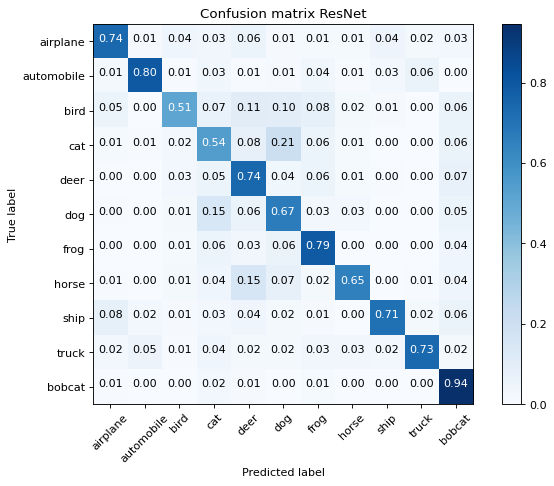

In [77]:
import keras

file = "resnet_tf.h5"
model = keras.models.load_model(file)
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title="Confusion matrix ResNet")

After training 20 epoch with `ResNet50V2` the training accuracy reaches to 94% and the validation accuracy is 71%. The difference between training and validation accuracy might indicate overfitting, but the model have a 94% accuracy when predicting `Bobcat` which is desirable.